In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

### Читаем датасет ###

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


### Преобразуем данные о времени ###
Возьмём час, месяц, год. Месяца берём по модулю 3, так как нас интересует начало сезона, середина и конец. 

In [4]:
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df['month'] = (pd.to_datetime(df['datetime']).dt.month) % 3 + 1
df['year'] = pd.to_datetime(df['datetime']).dt.year
df = df.drop(columns=['datetime'])
df[10300:10305]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year
10300,4,0,1,1,14.76,17.425,43,8.9981,20,161,181,14,3,2012
10301,4,0,1,1,14.76,16.665,43,19.0012,32,228,260,15,3,2012
10302,4,0,1,1,13.94,17.425,46,7.0015,31,290,321,16,3,2012
10303,4,0,1,1,13.12,15.910,49,12.9980,19,564,583,17,3,2012
10304,4,0,1,1,13.12,15.910,53,11.0014,24,543,567,18,3,2012


### Смотрим коррелирующие признаки

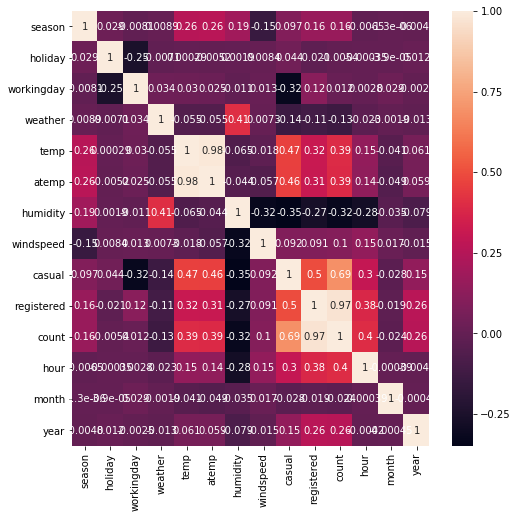

In [5]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)

Видно, что с ответом сильно коррелируют количество поездок зраегистрированных и незарегистрированных пользователей. Также фактическая температура очень сильно коррелирует с ощущаемой, удаляем.

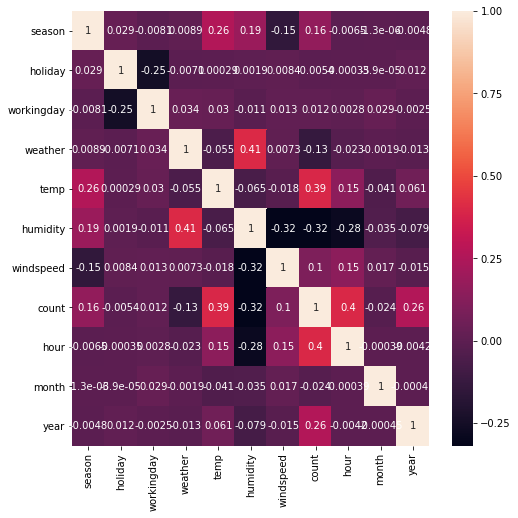

In [6]:
df = df.drop(columns=['atemp', 'registered', 'casual'])
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)

### Отделяем лейблы

In [7]:
y_df = df['count']
x_df = df.drop(columns=['count'])
x_df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,hour,month,year
0,1,0,0,1,9.84,81,0.0,0,2,2011
1,1,0,0,1,9.02,80,0.0,1,2,2011
2,1,0,0,1,9.02,80,0.0,2,2,2011
3,1,0,0,1,9.84,75,0.0,3,2,2011
4,1,0,0,1,9.84,75,0.0,4,2,2011


### Разбиваем на обучающее и тестовое множества

In [8]:
X, Y = np.array(x_df), np.array(y_df).reshape(len(y_df),)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

### Задаём модель, обучаем её и запускаем на тестовом множестве ###

In [9]:
model = DecisionTreeRegressor(max_depth=6, criterion='mse', random_state=17)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print('r2 score: ', model.score(X_test, Y_test))
print('MSE: ', mean_squared_error(Y_test, predictions))

r2 score:  0.6894376272486515
MSE:  10474.937773946805


#### Дерево выглядит следующим образом:

In [10]:
export_graphviz(model, out_file='tree.dot', feature_names=x_df.columns, filled=True)

![](tree.png)

#### Попробуем поднять точность, подобрав параметры.

In [11]:
params = {'max_depth': np.arange(1, 31), 'max_features': np.arange(1, 11)}

grid = GridSearchCV(model, params, n_jobs=-1, cv=5)

grid.fit(X_train, Y_train)

grid.best_params_

{'max_depth': 12, 'max_features': 9}

In [12]:
predictions = grid.predict(X_test)
print('r2 score: ', grid.score(X_test, Y_test))
print('MSE: ', mean_squared_error(Y_test, predictions))

r2 score:  0.9045536871607177
MSE:  3219.3023864633665


### Отрисовать дерево нормально не получается уже на глубине 12.

In [13]:
export_graphviz(grid.best_estimator_, out_file='tree_grid.dot', feature_names=x_df.columns, filled=True)

![](tree_grid.png)